In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def mlp(r_i, r_d, N_i, N_h, N_o, training_steps=5000, lr=0.7, batch_size=1):

    # Initialize randomly the weights
    # Hidden layer
    w_h = np.random.rand(N_h+1,N_i) - 0.5
    # Output layer
    w_o=np.random.rand(N_o,N_h+1) - 0.5

    mse = []

    for ti in range(training_steps):
        # Select training pattern randomly
        #i = np.floor(4*np.random.rand()).astype('int')
        for bi in range(batch_size):
            # Feed-forward the input to hidden layer
            i = np.floor(np.shape(r_i)[1]*np.random.rand()).astype('int')
            r_h = 1 / (1 + np.exp(-w_h*r_i[:,i]))
            r_h[-1] = 1  # Bias from hidden to output layer
            #r_h = np.concatenate((r_h, np.ones((1,1))), axis=0)
            # Feed-forward the input to the output layer
            r_o = 1 / (1 + np.exp(-w_o*r_h))
            # Calculate the network error
            d_o = np.multiply(np.multiply(r_o, 1-r_o), r_d[:,i] - r_o)
            # Calculate the responsability of the hidden network in the error
            d_h = np.multiply(np.multiply(r_h, (1-r_h)), (w_o.T*d_o))
            # Update weights
            w_o = w_o + lr*(r_h*d_o.T).T
            w_h = w_h + lr*(r_i[:,i]*d_h.T).T
            
        # Test all patterns
        #r_o_test = 1 / (1 + np.exp(-w_o*(1/(1+np.exp(-w_h*r_i)))))
        rht = 1 / (1 + np.exp(-w_h*r_i))
        rht[-1] = 1
        r_o_test = 1 / (1 + np.exp(-w_o*rht))
        mse += [mean_squared_error(r_d, r_o_test)]
        
    return mse, r_o_test, w_h, w_o

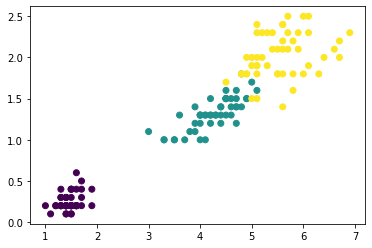

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, 2:4]  # Feature selection
y = iris.target
plt.scatter(X[:,0], X[:,1], c=y)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [4]:
y_test, np.unique(y_test, return_counts=True)

(array([2, 0, 0, 1, 0, 2, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 1, 1, 1,
        1, 2, 1, 2, 0, 2, 0, 1]),
 (array([0, 1, 2]), array([10, 10, 10])))

In [5]:
one_hot_my_encoding = np.zeros((len(y_test), len(np.unique(y_test))))
for i,yi in enumerate(y_test):
    one_hot_my_encoding[i][yi] = 1 
one_hot_my_encoding[:10] 

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

mlp_encoding = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

X_train = np.concatenate((X_train, np.ones((120,1))), axis=1)  # bias

r_i = np.matrix(X_train.transpose())
r_d = np.matrix(mlp_encoding.transpose())

mlp_encoding[:5]  # First five items

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

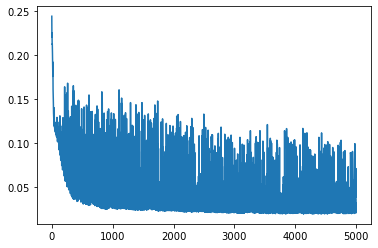

In [7]:
N_i = 3; N_h = 2; N_o = 3

result = mlp(r_i, r_d, N_i, N_h, N_o, training_steps=5000, lr=0.8, batch_size=10)

plt.plot(result[0])

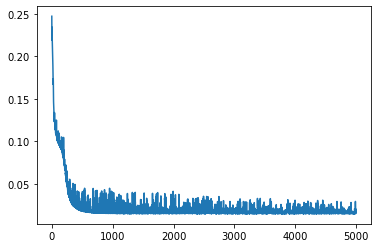

In [8]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.preprocessing import MinMaxScaler

X = iris.data[:, 2:4]  # Feature selection
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = np.concatenate((X_train_scaled, np.ones((120,1))), axis=1)
mlp_encoding = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
r_i = np.matrix(X_train_scaled.transpose())
r_d = np.matrix(mlp_encoding.transpose())

# Parameters, neurons: input, hidden, output
N_i = 3; N_h = 2; N_o = 3

result = mlp(r_i, r_d, N_i, N_h, N_o, training_steps=5000, lr=0.8, batch_size=10)
plt.plot(result[0])

<AxesSubplot:>

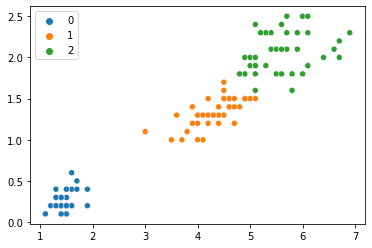

In [9]:
y_pred = [np.where(result[1].T[i] == result[1].T[i].max())[1][0] for i in range(len(y_train))]
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_pred, palette=sns.color_palette("tab10")[:3])

<AxesSubplot:>

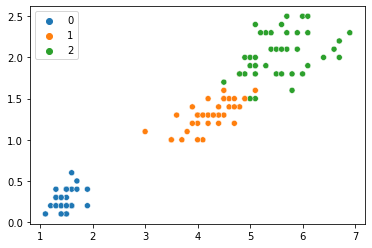

In [10]:
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, palette=sns.color_palette("tab10")[:3])

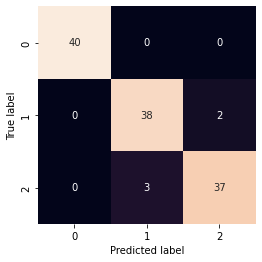

In [11]:
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.95      0.94        40
           2       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



In [13]:
np.diag(cm).sum() / cm.sum()

0.9583333333333334

Ver: 
- https://en.wikipedia.org/wiki/Precision_and_recall
- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

<AxesSubplot:>

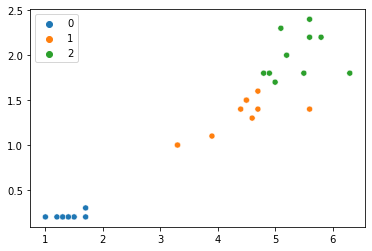

In [14]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.concatenate((X_test_scaled, np.ones((30,1))), axis=1)
r_i = np.matrix(X_test_scaled.transpose())

def mlp_predict(r_i, w_h, w_o):
    # Test all patterns
    #r_o_test = 1 / (1 + np.exp(-w_o*(1/(1+np.exp(-w_h*r_i)))))
    rht = 1 / (1 + np.exp(-w_h*r_i))
    rht[-1] = 1
    r_o_test = 1 / (1 + np.exp(-w_o*rht))
    return r_o_test

result_test = mlp_predict(r_i, result[2], result[3])
y_pred = [np.where(result_test.T[i] == result_test.T[i].max())[1][0] for i in range(len(y_test))]
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_pred, palette=sns.color_palette("tab10")[:3])

<AxesSubplot:>

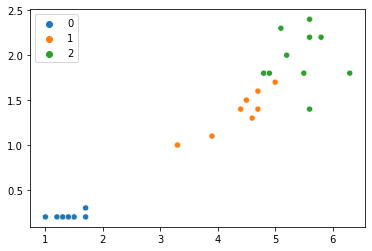

In [15]:
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, palette=sns.color_palette("tab10")[:3])

In [16]:
x_min, y_min = X.min(axis=0)
x_max, y_max = X.max(axis=0)
x_min, y_min, x_max, y_max

(1.0, 0.1, 6.9, 2.5)

In [17]:
gX = np.linspace(x_min, x_max, 100)
gY = np.linspace(y_min, y_max, 100)

gData = np.concatenate((gX.reshape(-1,1), gY.reshape(-1,1)), axis=1)
gData_scaled = scaler.transform(gData)

gData_scaled = np.concatenate((gData_scaled, np.ones((100,1))), axis=1)
r_i = np.matrix(gData_scaled.transpose())

result_test = mlp_predict(r_i, result[2], result[3])
y_pred = [np.where(result_test.T[i] == result_test.T[i].max())[1][0] for i in range(100)]

In [18]:
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [19]:
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
                     
Xgd = gData_scaled[:,0]
Ygd = gData_scaled[:,1]

Z = []
for xi in Xgd:
    for yi in Ygd:
        z_result = mlp_predict(np.array([[xi, yi, 1]]).T, result[2], result[3])
        #Z += [z_result[2]]
        Z += [np.where(z_result == z_result.max())[0][0]]

<AxesSubplot:>

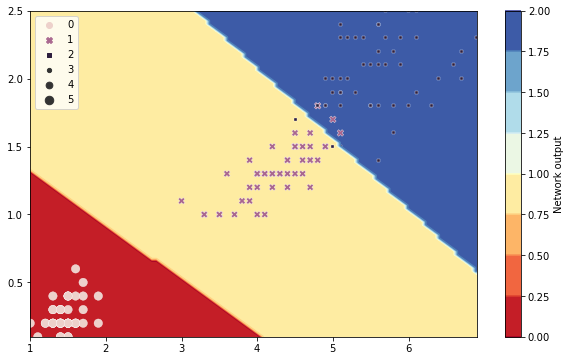

In [20]:
plt.figure(figsize=(10,6))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Plot contour
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
csl = plt.contour(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Make a colorbar for the cs returned by the contourf call.
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('Network output')
# Add the contour line levels to the colorbar
cbar.add_lines(csl)

sns.scatterplot(X[:,0], X[:,1], hue=y, style=y, size=5-y)

In [21]:
confusion_matrix(y, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [150, 100]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cce3455d-da08-4c10-a6fe-39f2a30c6a51' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>